# apply instruments settings

In [ ]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

import math
from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF, REPEAT_INFINITELY
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer
from hardware.daq.sidig import FIFO_DataAcquisition, DCCOUPLE, TERMIN_INPUT_50OHM, TERMIN_INPUT_1MOHM

from hardware import config as hcf

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE

from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np
import matplotlib.pyplot as plt
from spcm import units

: 

In [2]:
# connect to devices
uncal_choffset = {"laser":0, 
                "sdtrig":0, 
                "dtrig":900,
                "mwA":0, 
                "mwB":0,
                }
pg  = PulseGenerator(ip=hcf.PS_IP, chmap=hcf.PS_chmap, choffs=uncal_choffset) 
mwsyn = Synthesizer(hcf.VDISYN_SN, 
                    vidpid=hcf.VDISYN_VIDPID,
                    baudrate=hcf.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()
dig = FIFO_DataAcquisition(
                sn_address=hcf.SIDIG_ADDRESS
            )
laser = LaserControl(hcf.LASER_SN)
laser.open()

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 192.168.1.26
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0


SerialException: could not open port 'COM3': PermissionError(13, 'Access is denied.', None, 5)

In [3]:
# # QUICK RESET 

# # turn off laser and set diode current to zero
# laser.laser_off() 
# laser.set_diode_current(0, save_memory=False)
# laser.close()
# # reset pulse generator
# pg.forceFinal()
# pg.constant(OutputState.ZERO())
# pg.reset()
# # pg.reboot()

# # close all NI tasks
# # readtask.stop()
# # readtask.close()
# # task_uca.stop()
# # task_uca.close()
# # task_mwbp.stop()
# # task_mwbp.close()

# # reboot(optional) and close the MW synthesizer 
# # mwsyn.reboot()
# mwsyn.close()

# Set parameters

In [4]:
# set current================================================
current_percent = 70.05


laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [5]:
# set MW frequency =====================================================
f_NVguess = 398.5462701022625
# f_NVguess = 392.845
# f_NVguess = 398.555
freq = f_NVguess/24.0

errorbyte, freq_actual = mwsyn.cw_frequency(freq)
print(f"CW Freqeuncy Setting Sent:{freq} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

CW Freqeuncy Setting Sent:16.60609458759427 GHz
Actual Output CW Freqeuncy :16.60609458759427 GHz


In [6]:
# set MW power =====================================================
mwpower_vlevel = 5.0 # 5V equals to max p|ower
task_uca = nidaqmx.Task("UCA") # user controlled attenuation
task_uca.ao_channels.add_ao_voltage_chan(hcf.NI_ch_UCA, min_val=0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_uca.start()
task_uca.write([mwpower_vlevel], auto_start=False)
# task_uca.stop()
# task_uca.close()

1

In [7]:
# set MW phase =====================================================
mwphase_vlevel = 0.0 # voltage to phase shifter
task_mwbp = nidaqmx.Task("MW B Phase") # user controlled attenuation
task_mwbp.ao_channels.add_ao_voltage_chan(hcf.NI_ch_MWBP, min_val=0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_mwbp.start()
task_mwbp.write([mwphase_vlevel], auto_start=False)
# task_uca.stop()
# task_uca.close()

1

In [8]:
def seqtime(seq_tb):
    return np.sum([pulse[-1] for pulse in seq_tb])

In [9]:
pg.reset()
tb = hcf.NI_timebase
# init_laser = 8000.0

init_nslaser = 50
init_isc = 150
init_repeat = 40
init_wait = 1000.0

mw_dur_start = 10.0
mw_dur_end = 3500
mw_dur_step = 50
mw_dur = np.arange(mw_dur_start, mw_dur_end, mw_dur_step)[::-1] # reverse the mw 

mw_dur_num = len(mw_dur)
read_wait = 300.0
read_laser = 900.0



seq_exp = []


sub_init = [(["laser"], init_nslaser), ([], init_isc)]*init_repeat + [([], init_wait)]
# sub_init_fake = [([], init_nslaser), ([], init_isc)]*init_repeat + [([], init_wait)]

sub_evo_MW = [(["mwB"], mw_dur[0])]


sub_read = [([], read_wait), (["laser", "sdtrig"], read_laser),([],10)]
fake_read=[([], read_wait), (["sdtrig"], read_laser)]
# fake_fake_read=[([], read_wait), ([], read_laser)]

seq_exp += sub_init+ sub_evo_MW + sub_read #fake_read + sub_init

seqlet_time_max = seqtime(seq_exp)
srate = 1/seqlet_time_max*1E9 # in Hz

sub_evo_noMW = [([], mw_dur[0])]


seq_exp += sub_init + sub_evo_noMW + sub_read


for mwd in mw_dur[1:]:
# for mwd in mw_dur:

    sub_evo_MW = [(["mwB"], mwd)]

    seqlet_MW = sub_init+sub_evo_MW+sub_read

    seqlet_time = seqtime(seqlet_MW)
    padtime = seqlet_time_max - seqlet_time
    sub_pad = [([], padtime)]

    sub_evo_noMW = [([], mwd)]

    seqlet_noMW = sub_init+sub_evo_noMW+sub_read

    seq_exp += sub_pad + seqlet_MW + sub_pad + seqlet_noMW 


trigwidth = tb*20
# sub_dtrig = [(["dtrig"], trigwidth)]
sub_read = [([], read_wait), (["sdtrig"], read_laser)]
padtime = seqlet_time_max  - seqtime(sub_read)
seqlet_bias = [([], padtime)]  #+ sub_read
total_time = pg.setSequence(
    seqlet_bias + seq_exp
) 


In [10]:
def seqtime_tb(seq_tb):
    return np.sum([pulse[-1] for pulse in seq_tb])
def seqtime_cb(seq_cb):
    return np.sum([pulse[-0] for pulse in seq_cb])

In [11]:
pg.setTrigger(TriggerStart.SOFTWARE, rearm=TriggerRearm.AUTO)
REPEAT_INFINITELY = -1
pg.stream(n_runs=REPEAT_INFINITELY)
pg.plotSeq(plot_all=False)

In [12]:
# pg.forceFinal()
# pg.reset()

In [13]:
# # signal reading parameters
# min_volt = -0.005 # [V]
# max_volt = 0.010
# samplerate_read = srate # 500kHz .max ext clock rate of NI6343, check it by yourself!
# num_readmultiple = max(1, int(0.1/total_time*1E9))
# num_readsample = mw_dur_num*2 + 1
# buffer_size = num_readmultiple * num_readsample
# timeout_read = max(2*buffer_size/samplerate_read, 10)
# buffer_readpoint = np.zeros(buffer_size, dtype=np.float64, order='C')

# readtask = nidaqmx.Task("readsignal")
# # readtask.close()
# readtask.ai_channels.add_ai_voltage_chan(
#             hcf.NI_ch_APD,"",
#             TerminalConfiguration.DIFF,
#             min_volt,max_volt,
#             VoltageUnits.VOLTS
#         )
# # readtask.timing.cfg_samp_clk_timing(samplerate_read, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
# readtask.timing.cfg_samp_clk_timing(
#     samplerate_read, 
#     source=hcf.NI_ch_Clock, 
#     active_edge=Edge.RISING, 
#     sample_mode=AcquisitionType.CONTINUOUS)
# read_trig = readtask.triggers.start_trigger
# read_trig.cfg_dig_edge_start_trig(hcf.NI_ch_Trig, Edge.RISING)

# reader = AnalogSingleChannelReader(readtask.in_stream)
# reader.read_all_avail_samp  = True

## Configure Digitizer

In [14]:
# min_volt = -0.002 # [V]
# max_volt = 0.010 # [V]
rate_refresh = 10 # Hz rate of refreshing the data streaming
amp_input = 1000
readout_ch = hcf.SIDIG_chmap["apd"]
t_seq = total_time
num_segment = int(2/rate_refresh*1e9/t_seq)//32*32

# configures the readout to match the pulse sequence  
pretrig_size=int((read_wait/2)*hcf.SIDIG_maxsr/1E9)//64*64 # pretrigger based on the t_wait time
posttrig_size=int((read_laser)*hcf.SIDIG_maxsr/1E9)//64*64 # posttrigger based on the t_laser time and init_isc
segment_size = pretrig_size+posttrig_size
segment_size = 2**int(np.log2(segment_size)+1) # make it power of 2
posttrig_size = segment_size-pretrig_size # recalculate posttrigger size to ensure it is power of 2

In [15]:
# To set the configuration, make a dictionary with the key and value
dig.reset_param()
dig.assign_param(dict(
             readout_ch=readout_ch, 
             amp_input=amp_input, 
             num_segment=num_segment,
             pretrig_size=pretrig_size+256,
             posttrig_size=posttrig_size-256,
             segment_size=segment_size,
             terminate_input=TERMIN_INPUT_1MOHM,
             couple_input=0
             ))


# Start measurement


In [16]:
# sig_bbloc = np.zeros((mw_dur_num, pretrig_size+posttrig_size), dtype=np.float64, order='C')
# sig_dbloc = np.zeros((mw_dur_num, pretrig_size+posttrig_size), dtype=np.float64, order='C')
# read_duration = 40 # read data for ? seconds
# # num_repeat = 10


# laser.laser_on() # turn on laser
# dig.set_config() # set the configuration
# dig.start_buffer() # start the buffer
# pg.startNow()
# start_time = time.time()



# idx_pointer = 0
# reps=0
# while time.time() - start_time < read_duration:

#     rawraw = dig.stream()
    
#     if rawraw is not None:
#         if reps ==0: 
#             num_segs = np.shape(rawraw)[0]
#             assert num_segs % 2 == 0
#             # seperate data into respective readout blocks
#             bg = rawraw[0, :, :]
#             idx_track = num_segs//2 # number of repititions of each data block type in pushed raw data     
#             idx_pointer+=idx_track
#             if idx_pointer >= mw_dur_num:
#                 reps+=1
#             idx_pointer = idx_pointer%mw_dur_num  
            
#         else:
#             num_segs = np.shape(rawraw)[0]
#             # assertion ensures the data is multiple of 4 for 4 readout block strucutre, 
#             # drbloc, brbloc, lbloc, ribloc
#             assert num_segs % 2 == 0

#             # seperate data into respective readout blocks
#             rawraw_bbloc = rawraw[0::2, :, :]
#             rawraw_dbloc = rawraw[1::2, :, :]

            
#             idx_track = num_segs//2 # number of repititions of each data block type in pushed raw data     
#             for i in range(idx_track):
#                 idx=(idx_pointer+i)%mw_dur_num
#                 sig_bbloc[idx,:]+=np.ravel(rawraw_bbloc[i])
#                 sig_dbloc[idx,:]+=np.ravel(rawraw_dbloc[i])
    
#                 # print(idx)
#             idx_pointer+=idx_track
#             if idx_pointer >= mw_dur_num:
#                 reps+=1
#             if reps ==5:
#                 break 
#             idx_pointer = idx_pointer%mw_dur_num  
            

# dig.stop_card()



In [17]:
# sig_bbloc = np.zeros((mw_dur_num, pretrig_size+posttrig_size), dtype=np.float64, order='C')
# sig_dbloc = np.zeros((mw_dur_num, pretrig_size+posttrig_size), dtype=np.float64, order='C')
read_duration = 15 # read data for ? seconds
# num_repeat = 10
data_store = np.zeros((2*mw_dur_num, pretrig_size+posttrig_size), dtype=np.float64, order='C')
bg_store= np.zeros((31139,pretrig_size+posttrig_size))
laser.laser_on() # turn on laser
dig.set_config() # set the configuration
dig.start_buffer() # start the buffer
pg.startNow()
start_time = time.time()


segments=np.zeros(2*mw_dur_num, dtype=np.float64, order='C')
idx_pointer = 0

while time.time() - start_time < read_duration:

    rawraw = dig.stream()
    
    if rawraw is not None:
       
        num_segs = np.shape(rawraw)[0]

        for i in range(num_segs):
            idx=(idx_pointer+i)%(2*mw_dur_num)
            data_store[idx,:]+=np.ravel(rawraw[i,:]) #-np.ravel(data_store[0,:])
            segments[idx]+=1
        idx_pointer+=num_segs
       

        idx_pointer = idx_pointer%(2*mw_dur_num)  
            

dig.stop_card()



SETTINGS: card timeout =  5 s
SETTINGS: # of segments =  1024 Sa
SETTINGS: sampling freq =  0.5 GHz
SETTINGS: pretrig size =  320 Sa
SETTINGS: termination =  0
notify size:  24576.0 Sa
Card stopped


In [18]:
# # sig_bbloc = np.zeros((mw_dur_num, pretrig_size+posttrig_size), dtype=np.float64, order='C')
# # sig_dbloc = np.zeros((mw_dur_num, pretrig_size+posttrig_size), dtype=np.float64, order='C')
# read_duration = 15 # read data for ? seconds
# # num_repeat = 10
# data_store = np.zeros((2*mw_dur_num+1, pretrig_size+posttrig_size), dtype=np.float64, order='C')
# bg_store= np.zeros((31139,pretrig_size+posttrig_size))
# laser.laser_on() # turn on laser
# dig.set_config() # set the configuration
# dig.start_buffer() # start the buffer
# pg.startNow()
# start_time = time.time()


# segments=np.zeros(2*mw_dur_num+1, dtype=np.float64, order='C')
# idx_pointer = 0

# while time.time() - start_time < read_duration:

#     rawraw = dig.stream()
    
#     if rawraw is not None:
       
#         num_segs = np.shape(rawraw)[0]

#         for i in range(num_segs):
#             idx=(idx_pointer+i)%(2*mw_dur_num+1)
#             data_store[idx,:]+=np.ravel(rawraw[i,:]) #-np.ravel(data_store[0,:])
#             segments[idx]+=1
#         idx_pointer+=num_segs
       

#         idx_pointer = idx_pointer%(2*mw_dur_num+1)  
            

# dig.stop_card()



In [19]:
# # sig_bbloc = np.zeros((mw_dur_num, pretrig_size+posttrig_size), dtype=np.float64, order='C')
# # sig_dbloc = np.zeros((mw_dur_num, pretrig_size+posttrig_size), dtype=np.float64, order='C')
# read_duration = 10 # read data for ? seconds
# # num_repeat = 10
# data_store = np.zeros((2*mw_dur_num, pretrig_size+posttrig_size), dtype=np.float64, order='C')
# bg_store= np.zeros((31139,pretrig_size+posttrig_size))
# laser.laser_on() # turn on laser
# dig.set_config() # set the configuration
# dig.start_buffer() # start the buffer
# pg.startNow()
# start_time = time.time()



# idx_pointer = 0
# reps=0
# while time.time() - start_time < read_duration:

#     rawraw = dig.stream()
    
#     if rawraw is not None:
       
#         num_segs = np.shape(rawraw)[0]
       
#         for i in range(num_segs):
#             idx=(idx_pointer+i)%(2*mw_dur_num)

#             data_store[idx,:]+=np.ravel(rawraw[i,:])-np.ravel(data_store[0,:])

#         idx_pointer+=num_segs
       
#         if idx_pointer >= (2*mw_dur_num):
#             reps+=1

#         idx_pointer = idx_pointer%(2*mw_dur_num)  
            

# dig.stop_card()



In [20]:
# sig_bbloc = np.zeros((mw_dur_num, pretrig_size+posttrig_size), dtype=np.float64, order='C')
# sig_dbloc = np.zeros((mw_dur_num, pretrig_size+posttrig_size), dtype=np.float64, order='C')
# read_duration = 40 # read data for ? seconds
# # num_repeat = 10


# laser.laser_on() # turn on laser
# dig.set_config() # set the configuration
# dig.start_buffer() # start the buffer
# pg.startNow()
# start_time = time.time()
# # while time.time() - start_time < read_duration:
# # # for kkk in range(num_repeat):
# #     # readtask.start() # ready to read data
# #     num_read = reader.read_many_sample(
# #             buffer_readpoint,
# #             buffer_size,
# #             timeout_read
# #         )
# #     # readtask.wait_until_done(timeout=timeout_read) # block the code below, optional
# #     raw = np.reshape(buffer_readpoint, (num_readmultiple, num_readsample))
# #     bg_bias = np.copy(raw[:, 0])
# #     signal_mw = np.copy(raw[:, 1::2]).T - bg_bias 
# #     signal_nomw = np.copy(raw[:, 2::2]).T - bg_bias

# #     sig_mw_av += np.sum(signal_mw, axis=1)
# #     sig_no_av += np.sum(signal_nomw, axis=1)
# #     # readtask.stop()
# #     num_repeat += num_readmultiple


# idx_pointer = 0
# reps=0
# bb_pos=0
# db_pos=1
# while time.time() - start_time < read_duration:

#     rawraw = dig.stream()
    
#     if rawraw is not None:
#         if idx_pointer==0: 
#             num_segs = np.shape(rawraw)[0]
#             assert num_segs % 3 == 0
#             bg=rawraw[0,:,:]
#             rawraw_bbloc = rawraw[bb_pos+1::2, :, :]
#             rawraw_dbloc = rawraw[db_pos+1::2, :, :]

                        
#             idx_track = (num_segs-1)//2 # number of repititions of each data block type in pushed raw data     
#             for i in range(idx_track):
#                 idx=(idx_pointer+i)%mw_dur_num
#                 sig_bbloc[idx,:]+=np.ravel(rawraw_bbloc[i])
#                 sig_dbloc[idx,:]+=np.ravel(rawraw_dbloc[i])

#             idx_pointer+=idx_track
            
#             idx_pointer = idx_pointer%mw_dur_num 
#         else:
#             num_segs = np.shape(rawraw)[0]
#             # assertion ensures the data is multiple of 4 for 4 readout block strucutre, 
#             # drbloc, brbloc, lbloc, ribloc
#             assert num_segs % 2 == 0

#             # seperate data into respective readout blocks
#             rawraw_bbloc = rawraw[0::2, :, :]
#             rawraw_dbloc = rawraw[1::2, :, :]

            
#             idx_track = num_segs//2 # number of repititions of each data block type in pushed raw data     
#             for i in range(idx_track):
#                 idx=(idx_pointer+i)%mw_dur_num
#                 sig_bbloc[idx,:]+=np.ravel(rawraw_bbloc[i])
#                 sig_dbloc[idx,:]+=np.ravel(rawraw_dbloc[i])
    
#                 # print(idx)
#             idx_pointer+=idx_track
#             if idx_pointer >= mw_dur_num:
#                 reps+=1
#             if reps ==5:
#                 break 
#             idx_pointer = idx_pointer%mw_dur_num  
            

# dig.stop_card()



In [35]:
# turn off laser and set diode current to zero
laser.laser_off() 
laser.set_diode_current(0, save_memory=False)
laser.close()
# reset pulse generator
pg.forceFinal()
pg.constant(OutputState.ZERO())
pg.reset()
# pg.reboot()

# close all NI tasks
# readtask.stop()
# readtask.close()
task_uca.stop()
task_uca.close()
task_mwbp.stop()
task_mwbp.close()

# reboot(optional) and close the MW synthesizer 
# mwsyn.reboot()
mwsyn.close()

DaqError: Task specified is invalid or does not exist.
Status Code: -200088

In [22]:
# def average_repeated_data(input_data, start, stop,index,reps):
#     arr=np.copy(input_data)
#     arr[1:index,:]/=(reps)
#     arr[index:]/=reps 
#     sliced_data=arr[:,start:stop]
#     averaged=np.mean(sliced_data, axis=1)
#     sliced_data=arr[:,0:300]
#     bg_averaged=np.mean(sliced_data, axis=1)

#     bloc1=averaged[0::2]-bg_averaged[0::2]
#     bloc2=averaged[1::2]-bg_averaged[1::2]
#     return( bloc1,bloc2)


In [23]:
# sig_bbloc=data_store[0::2,:]
# sig_dbloc=data_store[1::2,:]
# input=np.copy(data_store[1:])
# buffer_bbloc, buffer_dbloc = average_repeated_data(input, 400,800, idx_pointer,reps)



In [24]:
# idx_pointer

In [25]:
# import plotly.graph_objects as go
# fig = go.Figure()

# # Add traces
# i=69
# fig.add_trace(go.Scatter(y=sig_bbloc[i], mode='lines'))
# fig.add_trace(go.Scatter(y=sig_dbloc[i], mode='lines'))
# # fig.add_trace(go.Scatter(x=mw_dur, y=buffer_dbloc, mode='lines', name='Buffer D Bloc'))
# i=0
# fig.add_trace(go.Scatter(y=sig_bbloc[i], mode='lines'))
# fig.add_trace(go.Scatter(y=sig_dbloc[i], mode='lines'))
# i=2
# fig.add_trace(go.Scatter(y=sig_bbloc[i], mode='lines'))
# fig.add_trace(go.Scatter(y=sig_dbloc[i], mode='lines'))

# # fig.add_trace(go.Scatter(x=mw_dur, y=buffer_dbloc, mode='lines', name='Buffer D Bloc'))

# # Update layout
# fig.update_layout(
#     title="Rabi Data",
#     xaxis_title="MW Duration (ns)",
#     yaxis_title="Signal (V)",   
# )

In [26]:
# import plotly.graph_objects as go
# fig = go.Figure()

# # Add traces
# i=0
# fig.add_trace(go.Scatter(y=sig_bbloc[i], mode='lines'))
# fig.add_trace(go.Scatter(y=sig_dbloc[i], mode='lines'))
# # fig.add_trace(go.Scatter(x=mw_dur, y=buffer_dbloc, mode='lines', name='Buffer D Bloc'))
# i=1
# fig.add_trace(go.Scatter(y=sig_bbloc[i], mode='lines'))
# fig.add_trace(go.Scatter(y=sig_dbloc[i], mode='lines'))
# # i=2
# # fig.add_trace(go.Scatter(y=sig_bbloc[i], mode='lines'))
# # fig.add_trace(go.Scatter(y=sig_dbloc[i], mode='lines'))
# i=68
# fig.add_trace(go.Scatter(y=sig_bbloc[i], mode='lines'))
# fig.add_trace(go.Scatter(y=sig_dbloc[i], mode='lines'))

# # fig.add_trace(go.Scatter(x=mw_dur, y=buffer_dbloc, mode='lines', name='Buffer D Bloc'))

# # Update layout
# fig.update_layout(
#     title="Basic Plotly Template",
#     xaxis_title="MW Duration",
#     yaxis_title="Buffer Values",
#     legend=dict(x=0.01, y=0.99)
# )

# # Show plot
# fig.show()

In [27]:
# plt.plot(sig_bbloc[:,0:800].T)

In [28]:
# plt.plot(sig_dbloc[:,0:800].T)

In [29]:
# # plt.plot(mw_dur, buffer_bbloc/buffer_dbloc)
# # plt.plot(mw_dur,buffer_bbloc/np.max(buffer_bbloc))
# plt.plot(mw_dur,buffer_bbloc)

In [36]:
sig_bbloc=data_store[0::2,:]
sig_dbloc=data_store[1::2,:]
slice=data_store[:,400:800]
temp1=np.mean(slice, axis=1)
temp=temp1/segments



# buffer_bbloc, buffer_dbloc = average_repeated_data(input, 400,800, idx_pointer,reps)



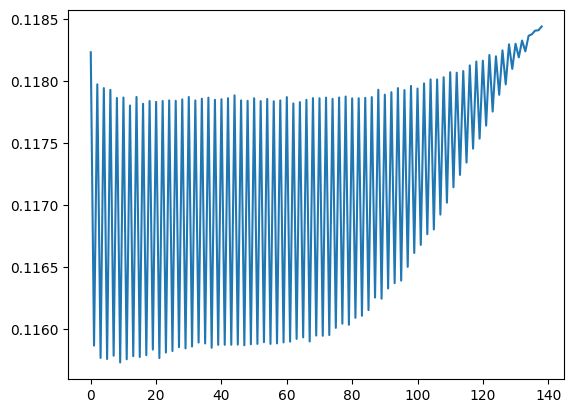

In [37]:
plt.plot(temp[1:])

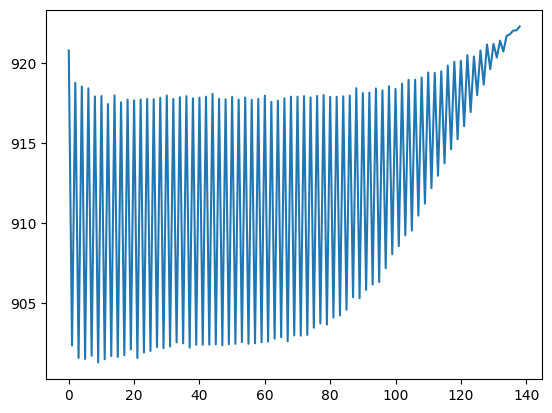

In [38]:
plt.plot(temp1[1:])

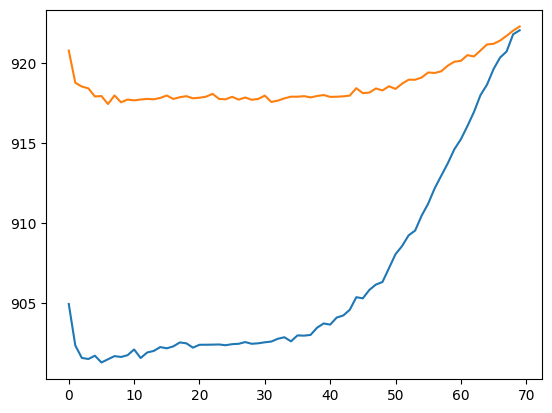

In [39]:
plt.plot(temp1[0::2])
plt.plot(temp1[1::2])

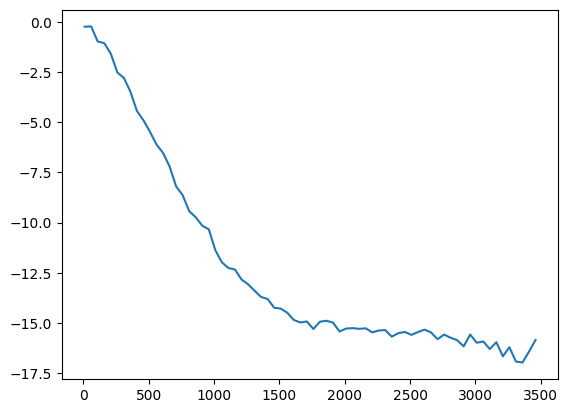

In [41]:
# plt.plot(temp1[1::2])
# plt.plot(temp1[2::2])
plt.plot(mw_dur,temp1[0::2]-temp1[1::2])